# Analysis for RTT geolocation whitepaper

This notebook has the same analysis code as [the paper](paper.ipynb), but no explanatory text. It's used for exploring alternate views of the same dataset.

In [1]:
%matplotlib inline

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats
import math

from mpl_toolkits.basemap import Basemap

import warnings
warnings.filterwarnings("ignore") 

# Some constants
c = 299792458 # speed of light in meters per second
EARTH_RADIUS = 6371 # radius of Earth in kilometers
FIBER_REFRACTION = 1.4677 # assume Corning glass is typical

# Running figure numbering
_fignum = 0
def fignum(label):
    global _fignum
    _fignum += 1
    return "Figure {}: {}".format(_fignum, label)

# Some utilities
def ecdf(ser):
    ser = ser.sort_values()
    cdf = np.linspace(0.,1.,len(ser))
    return pd.Series(cdf, index=ser)

def plot_rtt_series(aid, pid): 
    """
    Given an anchor and probe ID, plot the time series of RTTs, 
    separately for IPv4 and IPv6.
    
    """

    example_ts_df = rtt_df[(rtt_df['aid'] == aid) & (rtt_df['pid'] == pid)].loc[:,['time','rtt','af']]

    example_ts_df_ip4 = example_ts_df[example_ts_df['af'] == 4]
    example_ts_df_ip6 = example_ts_df[example_ts_df['af'] == 6]
    plt.plot(example_ts_df_ip4['time'],example_ts_df_ip4['rtt'],".")

    plt.plot(example_ts_df_ip6['time'],example_ts_df_ip6['rtt'],".")

    plt.xlabel("time")
    plt.ylabel("RTT µs")
    plt.legend(labels=['ip4','ip6'])
    plt.title(fignum("RTT series for {} ({}) from probe {}".format(anchor_df.loc[aid]['name'], aid, pid)))

def _point_at_bearing(lon1, lat1, b, r):
    """
    Shoot a bearing at a given distance (in units of Earth radius) from a given long
    """
    lon1 = lon1 * math.pi / 180.0
    lat1 = lat1 * math.pi / 180.0 # convert to radians

    b = (b / 90) * math.pi / 2


    lat2 = math.asin(math.sin(lat1) * math.cos(r) + math.cos(lat1) * math.sin(r) * math.cos(b))
    lon2 = lon1 + math.atan2(math.sin(b) * math.sin(r) * math.cos(lat1), 
                             math.cos(r) - math.sin(lat1) * math.sin(lat2))
    
    lon2 = 180.0 * lon2 / math.pi
    lat2 = 180.0 * lat2 / math.pi

    return lon2, lat2

def _circle_with_radius(lon, lat, km):
    """
    Return lat/lon coordinate vectors of a circle 
    with a given radius in kilometers
    """
    latArray = []
    lonArray = []
    
    for bearing in range(0,360):
        lon2, lat2 = _point_at_bearing(lon, lat, bearing, km / EARTH_RADIUS)
        latArray.append(lat2)
        lonArray.append(lon2)
        
    return lonArray, latArray

def plot_exclusion_circles_for(aid, amin_df=None, pids=None, mapscale=None, whichkm='fiber_km'):
    # First, get a dataframe containing only the datapoints for the anchor and probes selected
    if amin_df is None:
        amin_df = min_df.loc[aid].loc[pids]
    
    # Now draw the basemap, scaled to fit most of the circles we'll draw
    if mapscale is None:
        mapscale = amin_df[whichkm].max() * 2500 
    alon = amin_df.iloc[0]['alon']
    alat = amin_df.iloc[0]['alat']
    plt.figure(figsize=(10,10))
    try:
        m = Basemap(width=mapscale,height=mapscale,
                    resolution='i',projection='laea',
                    lat_ts=alat,lat_0=alat,lon_0=alon)
    except ValueError:
        m = Basemap(resolution='c',projection='robin',
                    lat_ts=alat,lat_0=alat,lon_0=alon)
    m.drawcoastlines()
    m.drawcountries()
    m.fillcontinents(color='white',lake_color='#dddddd')
    m.drawmapboundary(fill_color='#dddddd')
    
    # Now plot circles
    for index, row in amin_df.iterrows():
        x, y = m(row['plon'],row['plat'])
        km = row[whichkm]
        if km > ( EARTH_RADIUS * math.pi ):
            continue
        clon, clat = _circle_with_radius(row['plon'], row['plat'], km)
        X, Y = m(clon, clat)
        plt.plot(X, Y, 'b-', alpha=0.33)
    
    # And plot a dot for the anchor
    x, y = m(alon, alat)
    plt.plot(x, y, "ro")
    
    # And title
    if len(amin_df) == 1:
        plt.title(fignum("Exclusion circle for probe {} around {}".format(amin_df.iloc[0].name, anchor_df.loc[aid]['name'])))
    else:
        plt.title(fignum("Exclusion circles for {} probes around {}".format(len(amin_df), anchor_df.loc[aid]['name'])))

def plot_exclusion_circles_by_rtt(aid, max_rtt=None, mapscale=None, whichkm = 'fiber_km'):
    # First, get a dataframe containing only the datapoints for the anchor
    amin_df = min_df.loc[aid]
    
    # Drop probes over max RTT
    if max_rtt is not None:
        amin_df = amin_df[amin_df['minrtt'] < max_rtt]
        # If max RTT leads to too few probes, drop it
        if len(amin_df) < 3:
            amin_df = min_df.loc[aid]

    plot_exclusion_circles_for(aid, amin_df=amin_df, mapscale=mapscale, whichkm=whichkm)

        
def plot_linfit_rtt_by_dist(plot_df, use_log=True, figsize=(12,8), label="all pairs", rtt_max=None):
    """
    Show a hexbin plot of correlating minumum RTT with ground truth distance 
    """
    plt.figure(figsize=figsize)
    x = plot_df['km']
    y = plot_df['minrtt']
    if use_log:
        plt.hexbin(x, y, cmap="Greys", bins="log")
    else:
        plt.hexbin(x, y, cmap="Greys")
    plt.colorbar()
    plt.xlabel("distance (km)")
    plt.ylabel("rtt (µs)")
    if rtt_max:
        plt.ylim(0,rtt_max)

    (slope, intercept, r, p, e) = scipy.stats.linregress(plot_df['km'],plot_df['minrtt'])
    plt.plot(x, slope * x + intercept)
    
    if use_log:
        scaletitle = "log10 count"
    else:
        scaletitle = "count"
    plt.title(fignum("RTT by distance for {0} ({1}, y = {2:.3f}x+{3:.0f}, r = {4:.2f})".format(label, scaletitle, slope, intercept, r)))
    
    return (slope, intercept)

In [2]:
## Now load some data from the HDF store the dataprep notebook left us.
    
with pd.HDFStore('rtt_31Aug.h5') as store:
    anchor_df = store['anchor_df']
    probe_df = store['probe_df']
    rtt_df = store['rtt_df']

In [3]:
def make_min_df(rtt_df):
    min_df = pd.DataFrame({'minrtt': rtt_df.groupby(['aid','pid'])['rtt'].min(), 
                           'n':      rtt_df.groupby(['aid','pid'])['rtt'].count()})
    loc_by_aid = anchor_df.loc[:,('lon','lat')]
    loc_by_aid.columns = ['alon','alat']
    loc_by_pid = probe_df.loc[:,('lon','lat')]
    loc_by_pid.columns = ['plon','plat']
    min_df = loc_by_pid.join(loc_by_aid.join(min_df, how="inner"), how="inner")

    # calculate distance from probe/anchor locations reportsd in Atlas
    min_df['tmp_aphi'] = (90.0 - min_df['alat']) * math.pi/180.0
    min_df['tmp_pphi'] = (90.0 - min_df['plat']) * math.pi/180.0
    min_df['tmp_atheta'] = min_df['alon'] * math.pi/180.0
    min_df['tmp_ptheta'] = min_df['plon'] * math.pi/180.0
    min_df['tmp_cos'] = ( np.sin(min_df['tmp_aphi']) * np.sin(min_df['tmp_pphi']) * 
                          np.cos(min_df['tmp_atheta'] - min_df['tmp_ptheta']) + 
                          np.cos(min_df['tmp_aphi']) * np.cos(min_df['tmp_pphi']) )
    min_df['km'] = np.arccos(min_df['tmp_cos']) * EARTH_RADIUS
    del min_df['tmp_aphi']
    del min_df['tmp_pphi']
    del min_df['tmp_atheta']
    del min_df['tmp_ptheta']
    del min_df['tmp_cos']

    # determine lightspeed and fiber-assumption exclusion circle radii
    min_df['c_km'] = (c / 1e9) * (min_df['minrtt'] / 2)
    min_df['fiber_km'] = ((c / 1e9) / FIBER_REFRACTION) * (min_df['minrtt'] / 2)
    
    return min_df

# one big min df
min_df = make_min_df(rtt_df)

# and now one per hour
min_df_h = []
for h in range(0,22):
    start_time = "2017-08-31 {0:2d}:00:00".format(h)
    end_time = "2017-08-31 {0:2d}:00:00".format(h+1)
    min_df_h.append(make_min_df(rtt_df[(rtt_df['time'] >= start_time) & (rtt_df['time'] < end_time)]))

min_df_h.append(make_min_df(rtt_df[rtt_df['time'] >= '2017-08-31 23:00:00']))

## Results 


### Correlation between Distance and Minimum Delay

For each of our samples, we have probe and anchor latitude and longitude, from which we derive a spherical-approximated great circle distance. We can then see how well the minimum round-trip time sample for a given anchor/probe pair correlates with the actual distance. In an ideal situation (i.e., where $RTT_{min} = RTT_{ideal}$), this relationship is linear and governed by the speed of light, so we attempt a linear correlation in the figure below. Here, bins are colored on a log scale by the number of samples falling within them. Here we can see our dataset is biased toward short-distance, low-RTT samples, which is a consequence of the relative density of probes in anchors in Europe, which is small and well-connected. The blue line represents this linear fit.

Similarly, the orange line represents the circle of exclusion by the speed of light ($ dist < \frac{RTT_{obs}}{2} \times c $), and shows that the actual relationship between RTT and distance differs significantly from its theoretical bounds. One explanation for this feature is the predominance of optical fiber in long-haul Internet links, and the fact that the speed of light in optical fiber is determined by its index of refraction; we plot the circle of exclusion by the speed of light in fiber with the green line.




From these lines, we derive the following insights: the correlation between distance and RTT is relatively good $(r = 0.88)$, but not good enough to build a linear model as input to trilateration, which requires exact distance estimates from the vantage points to the unknown point to trilaterate. All data points lie above the green line, with some datapoints at certain distances dominated by point-to-point submarine fiber links (~2500 and ~6000 km) lying very close to this theoretical ideal, but with the bulk of the data points lying well above. The difference in slope between the linear fit and the fiber exclusion circle, and the y-intercept of the linear fit, are explained by the contribution of non-ideal terms to RTT: 

$$ RTT_{error} = \sum_{n=0}^f(D_{queue_n} + D_{proc_n}) + \sum_{m=0}^r(D_{queue_m} + D_{proc_m}) + D_{app} > 0 $$

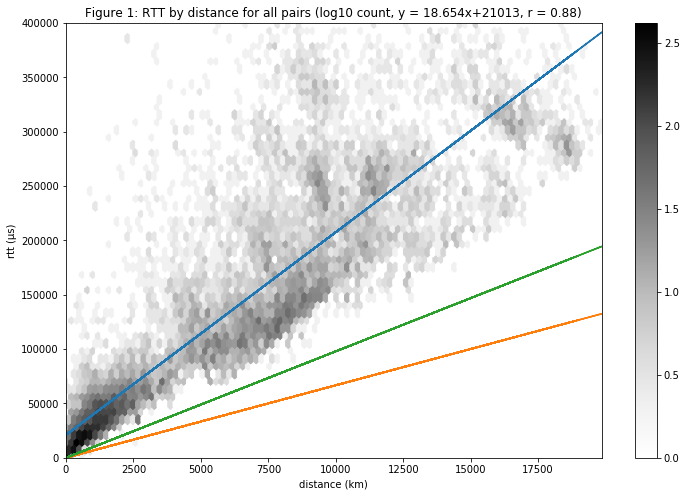

In [4]:
(linm, linb) = plot_linfit_rtt_by_dist(min_df, rtt_max=400000)
plt.plot(min_df['km'], min_df['km'] * 2e9 / c)
plt.plot(min_df['km'], min_df['km'] * 2e9 * FIBER_REFRACTION / c)

In [5]:
h = 0

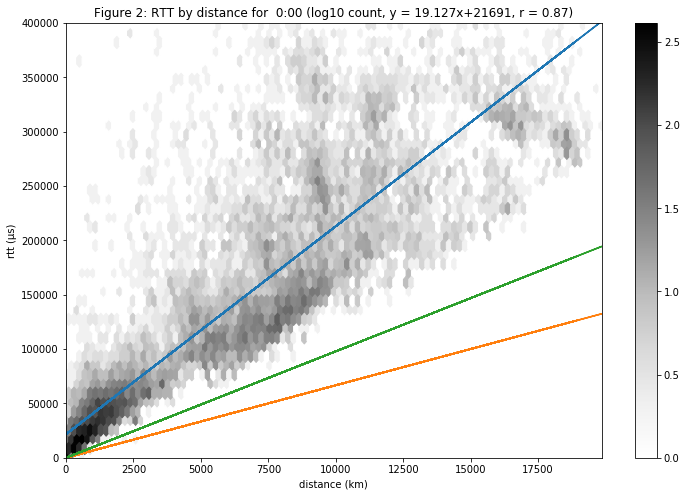

In [6]:
(linm, linb) = plot_linfit_rtt_by_dist(min_df_h[h], rtt_max=400000, label="{0:2d}:00".format(h))
plt.plot(min_df_h[h]['km'], min_df_h[h]['km'] * 2e9 / c)
plt.plot(min_df_h[h]['km'], min_df_h[h]['km'] * 2e9 * FIBER_REFRACTION / c)
h += 1

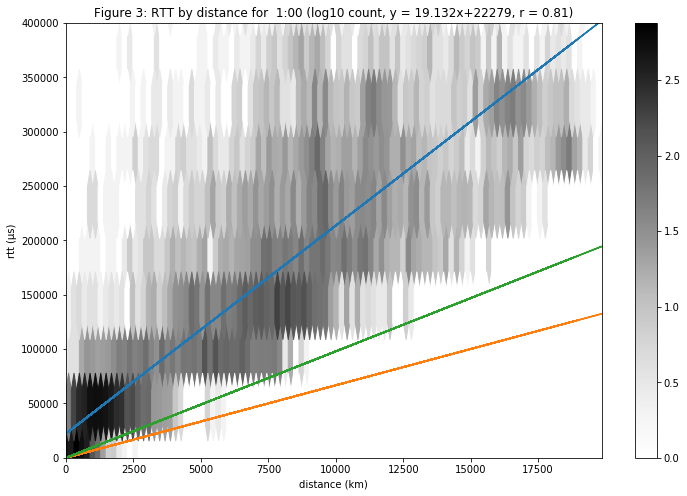

In [7]:
(linm, linb) = plot_linfit_rtt_by_dist(min_df_h[h], rtt_max=400000, label="{0:2d}:00".format(h))
plt.plot(min_df_h[h]['km'], min_df_h[h]['km'] * 2e9 / c)
plt.plot(min_df_h[h]['km'], min_df_h[h]['km'] * 2e9 * FIBER_REFRACTION / c)
h += 1

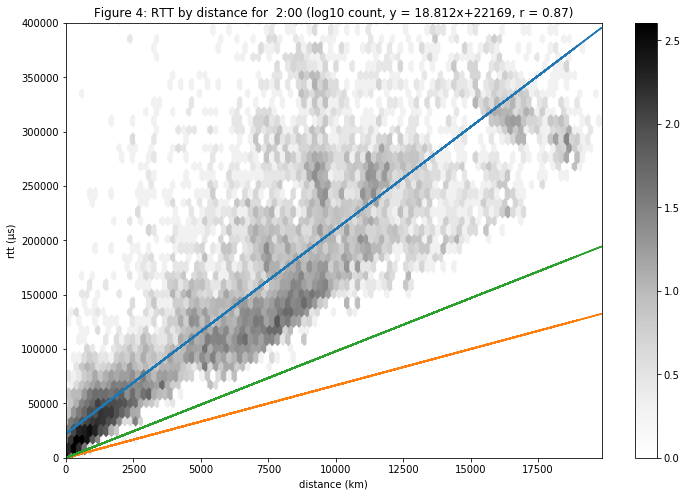

In [8]:
(linm, linb) = plot_linfit_rtt_by_dist(min_df_h[h], rtt_max=400000, label="{0:2d}:00".format(h))
plt.plot(min_df_h[h]['km'], min_df_h[h]['km'] * 2e9 / c)
plt.plot(min_df_h[h]['km'], min_df_h[h]['km'] * 2e9 * FIBER_REFRACTION / c)
h += 1

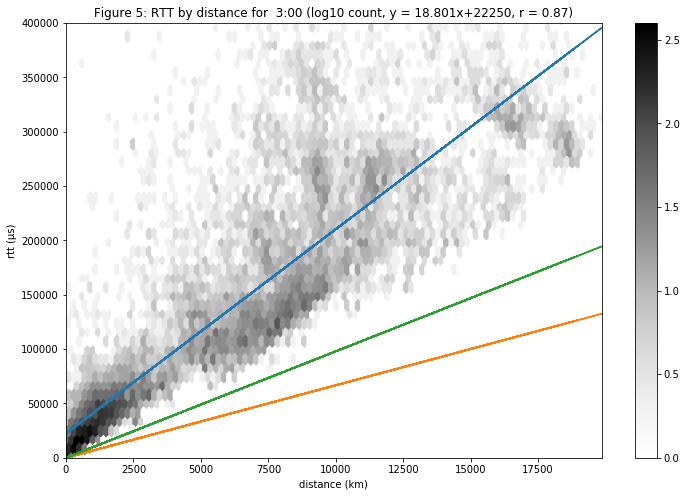

In [9]:
(linm, linb) = plot_linfit_rtt_by_dist(min_df_h[h], rtt_max=400000, label="{0:2d}:00".format(h))
plt.plot(min_df_h[h]['km'], min_df_h[h]['km'] * 2e9 / c)
plt.plot(min_df_h[h]['km'], min_df_h[h]['km'] * 2e9 * FIBER_REFRACTION / c)
h += 1

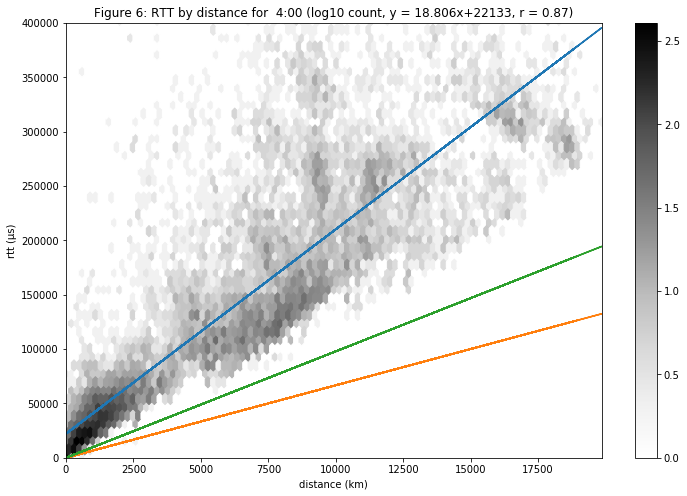

In [10]:
(linm, linb) = plot_linfit_rtt_by_dist(min_df_h[h], rtt_max=400000, label="{0:2d}:00".format(h))
plt.plot(min_df_h[h]['km'], min_df_h[h]['km'] * 2e9 / c)
plt.plot(min_df_h[h]['km'], min_df_h[h]['km'] * 2e9 * FIBER_REFRACTION / c)
h += 1

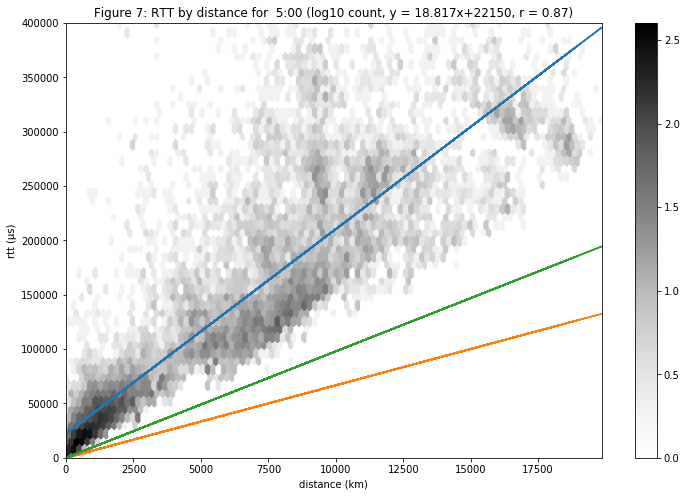

In [11]:
(linm, linb) = plot_linfit_rtt_by_dist(min_df_h[h], rtt_max=400000, label="{0:2d}:00".format(h))
plt.plot(min_df_h[h]['km'], min_df_h[h]['km'] * 2e9 / c)
plt.plot(min_df_h[h]['km'], min_df_h[h]['km'] * 2e9 * FIBER_REFRACTION / c)
h += 1

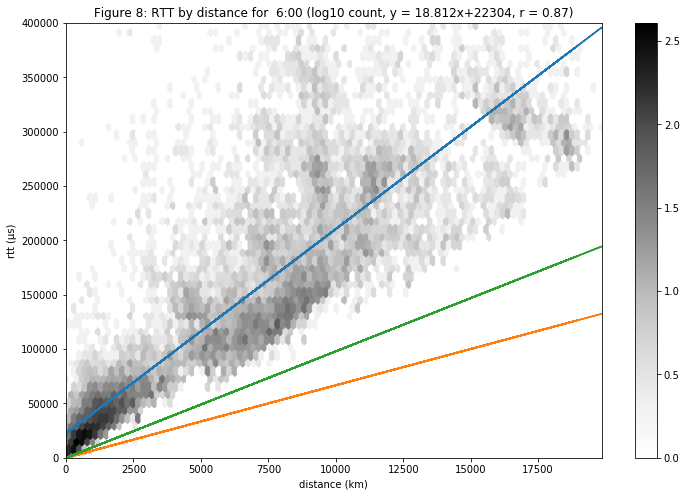

In [12]:
(linm, linb) = plot_linfit_rtt_by_dist(min_df_h[h], rtt_max=400000, label="{0:2d}:00".format(h))
plt.plot(min_df_h[h]['km'], min_df_h[h]['km'] * 2e9 / c)
plt.plot(min_df_h[h]['km'], min_df_h[h]['km'] * 2e9 * FIBER_REFRACTION / c)
h += 1

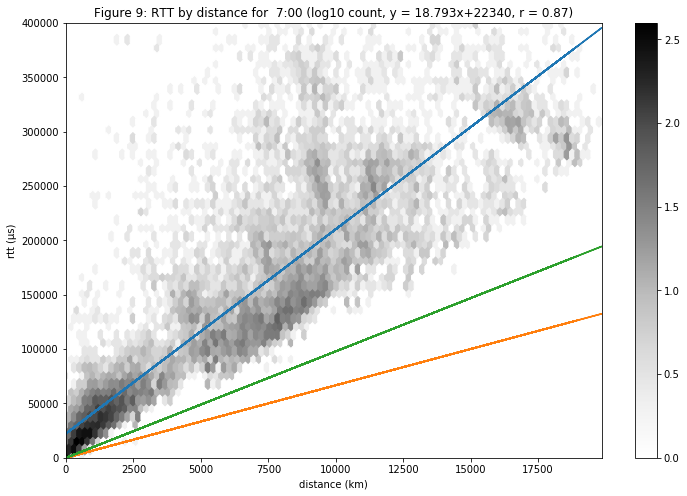

In [13]:
(linm, linb) = plot_linfit_rtt_by_dist(min_df_h[h], rtt_max=400000, label="{0:2d}:00".format(h))
plt.plot(min_df_h[h]['km'], min_df_h[h]['km'] * 2e9 / c)
plt.plot(min_df_h[h]['km'], min_df_h[h]['km'] * 2e9 * FIBER_REFRACTION / c)
h += 1

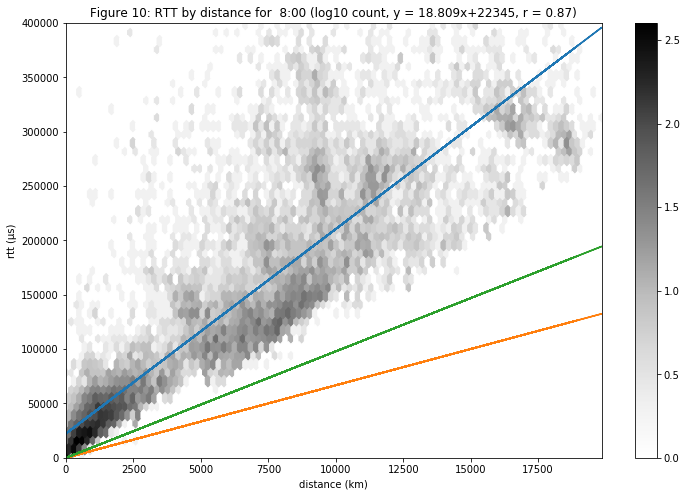

In [14]:
(linm, linb) = plot_linfit_rtt_by_dist(min_df_h[h], rtt_max=400000, label="{0:2d}:00".format(h))
plt.plot(min_df_h[h]['km'], min_df_h[h]['km'] * 2e9 / c)
plt.plot(min_df_h[h]['km'], min_df_h[h]['km'] * 2e9 * FIBER_REFRACTION / c)
h += 1

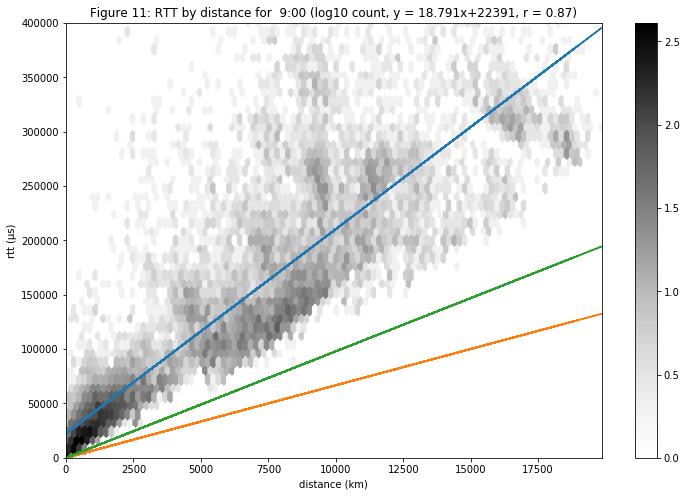

In [15]:
(linm, linb) = plot_linfit_rtt_by_dist(min_df_h[h], rtt_max=400000, label="{0:2d}:00".format(h))
plt.plot(min_df_h[h]['km'], min_df_h[h]['km'] * 2e9 / c)
plt.plot(min_df_h[h]['km'], min_df_h[h]['km'] * 2e9 * FIBER_REFRACTION / c)
h += 1

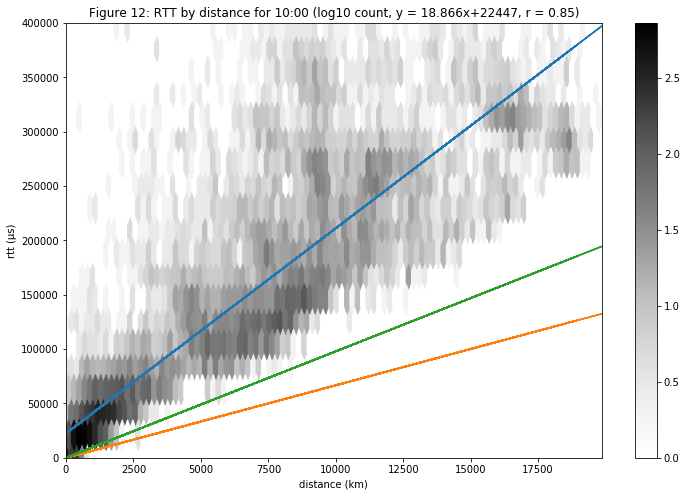

In [16]:
(linm, linb) = plot_linfit_rtt_by_dist(min_df_h[h], rtt_max=400000, label="{0:2d}:00".format(h))
plt.plot(min_df_h[h]['km'], min_df_h[h]['km'] * 2e9 / c)
plt.plot(min_df_h[h]['km'], min_df_h[h]['km'] * 2e9 * FIBER_REFRACTION / c)
h += 1

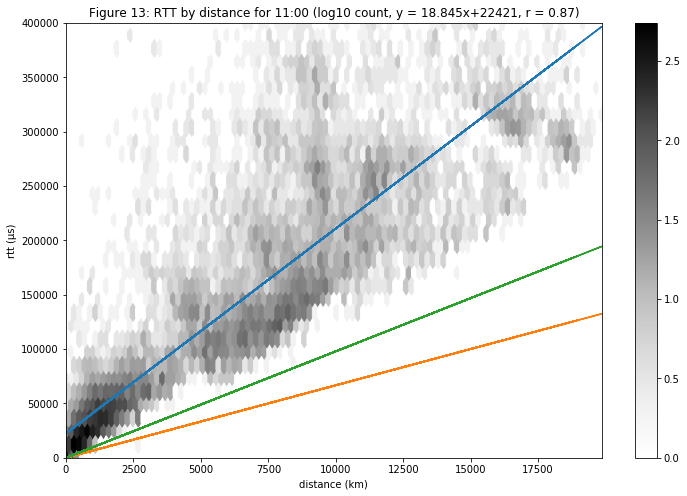

In [17]:
(linm, linb) = plot_linfit_rtt_by_dist(min_df_h[h], rtt_max=400000, label="{0:2d}:00".format(h))
plt.plot(min_df_h[h]['km'], min_df_h[h]['km'] * 2e9 / c)
plt.plot(min_df_h[h]['km'], min_df_h[h]['km'] * 2e9 * FIBER_REFRACTION / c)
h += 1

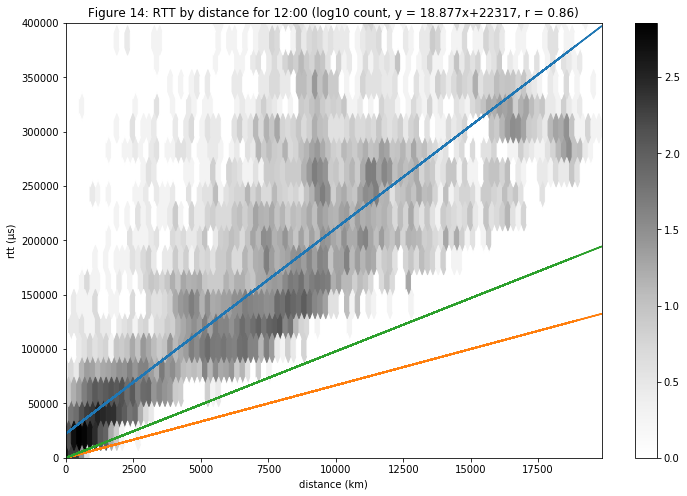

In [18]:
(linm, linb) = plot_linfit_rtt_by_dist(min_df_h[h], rtt_max=400000, label="{0:2d}:00".format(h))
plt.plot(min_df_h[h]['km'], min_df_h[h]['km'] * 2e9 / c)
plt.plot(min_df_h[h]['km'], min_df_h[h]['km'] * 2e9 * FIBER_REFRACTION / c)
h += 1

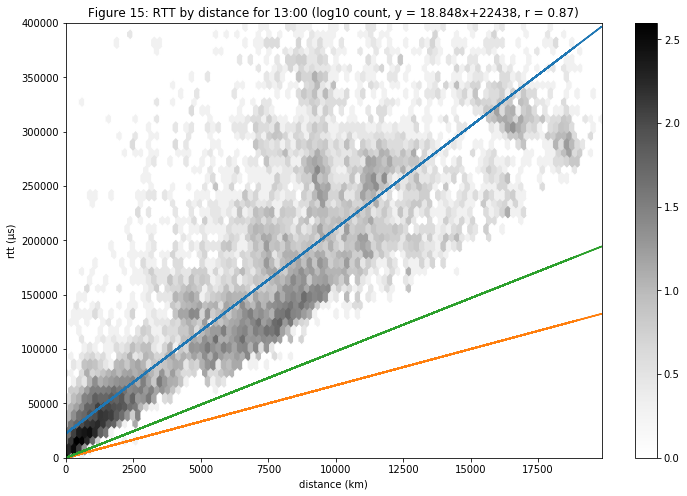

In [19]:
(linm, linb) = plot_linfit_rtt_by_dist(min_df_h[h], rtt_max=400000, label="{0:2d}:00".format(h))
plt.plot(min_df_h[h]['km'], min_df_h[h]['km'] * 2e9 / c)
plt.plot(min_df_h[h]['km'], min_df_h[h]['km'] * 2e9 * FIBER_REFRACTION / c)
h += 1

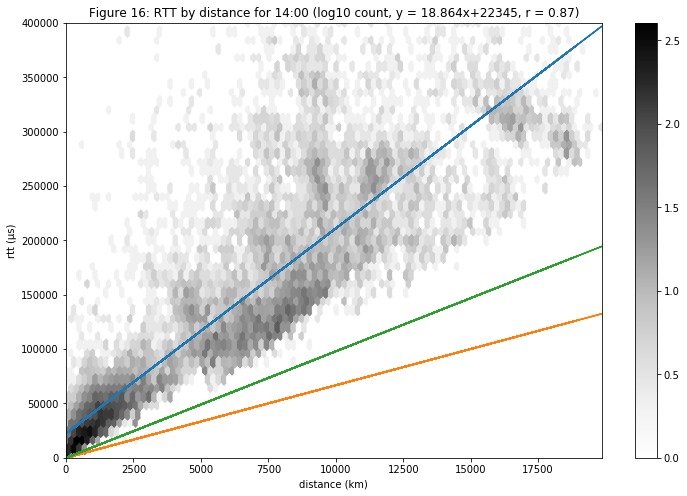

In [20]:
(linm, linb) = plot_linfit_rtt_by_dist(min_df_h[h], rtt_max=400000, label="{0:2d}:00".format(h))
plt.plot(min_df_h[h]['km'], min_df_h[h]['km'] * 2e9 / c)
plt.plot(min_df_h[h]['km'], min_df_h[h]['km'] * 2e9 * FIBER_REFRACTION / c)
h += 1

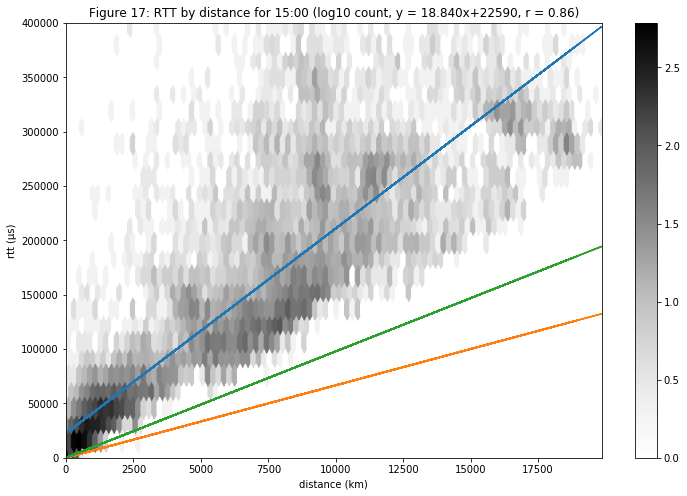

In [21]:
(linm, linb) = plot_linfit_rtt_by_dist(min_df_h[h], rtt_max=400000, label="{0:2d}:00".format(h))
plt.plot(min_df_h[h]['km'], min_df_h[h]['km'] * 2e9 / c)
plt.plot(min_df_h[h]['km'], min_df_h[h]['km'] * 2e9 * FIBER_REFRACTION / c)
h += 1

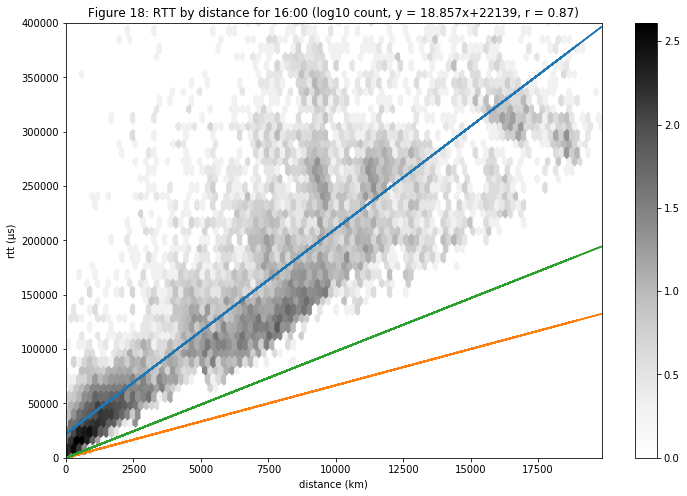

In [22]:
(linm, linb) = plot_linfit_rtt_by_dist(min_df_h[h], rtt_max=400000, label="{0:2d}:00".format(h))
plt.plot(min_df_h[h]['km'], min_df_h[h]['km'] * 2e9 / c)
plt.plot(min_df_h[h]['km'], min_df_h[h]['km'] * 2e9 * FIBER_REFRACTION / c)
h += 1

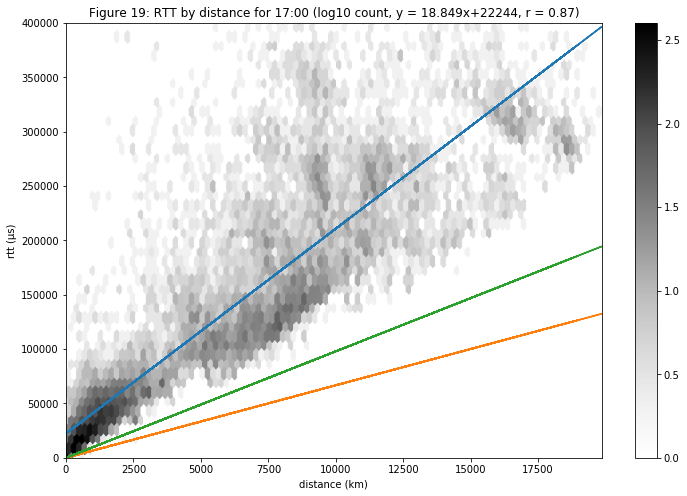

In [23]:
(linm, linb) = plot_linfit_rtt_by_dist(min_df_h[h], rtt_max=400000, label="{0:2d}:00".format(h))
plt.plot(min_df_h[h]['km'], min_df_h[h]['km'] * 2e9 / c)
plt.plot(min_df_h[h]['km'], min_df_h[h]['km'] * 2e9 * FIBER_REFRACTION / c)
h += 1

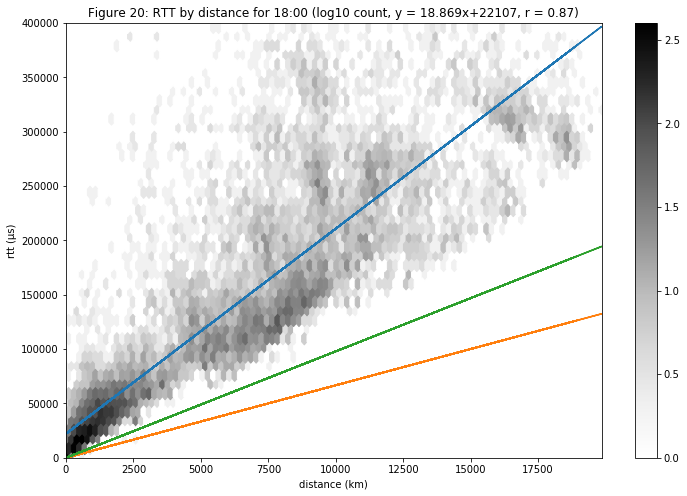

In [24]:
(linm, linb) = plot_linfit_rtt_by_dist(min_df_h[h], rtt_max=400000, label="{0:2d}:00".format(h))
plt.plot(min_df_h[h]['km'], min_df_h[h]['km'] * 2e9 / c)
plt.plot(min_df_h[h]['km'], min_df_h[h]['km'] * 2e9 * FIBER_REFRACTION / c)
h += 1

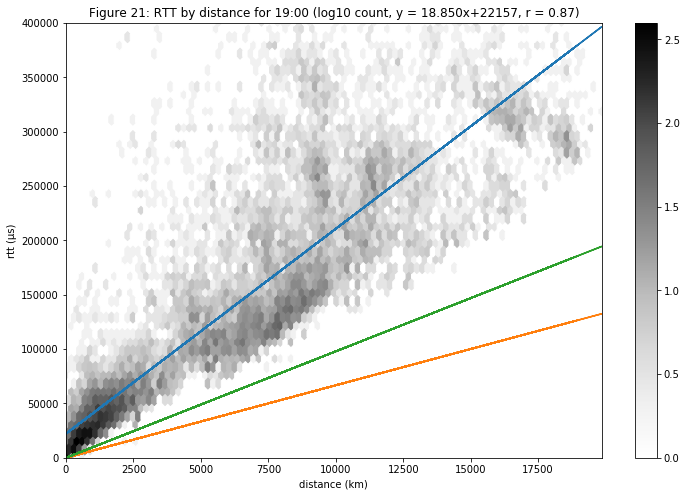

In [25]:
(linm, linb) = plot_linfit_rtt_by_dist(min_df_h[h], rtt_max=400000, label="{0:2d}:00".format(h))
plt.plot(min_df_h[h]['km'], min_df_h[h]['km'] * 2e9 / c)
plt.plot(min_df_h[h]['km'], min_df_h[h]['km'] * 2e9 * FIBER_REFRACTION / c)
h += 1

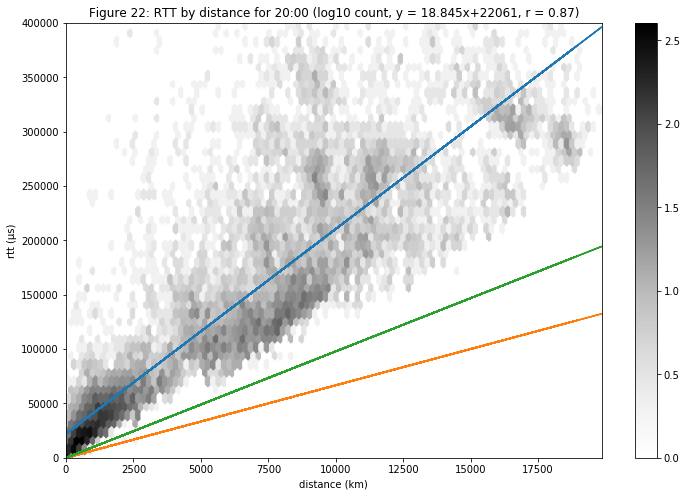

In [26]:
(linm, linb) = plot_linfit_rtt_by_dist(min_df_h[h], rtt_max=400000, label="{0:2d}:00".format(h))
plt.plot(min_df_h[h]['km'], min_df_h[h]['km'] * 2e9 / c)
plt.plot(min_df_h[h]['km'], min_df_h[h]['km'] * 2e9 * FIBER_REFRACTION / c)
h += 1

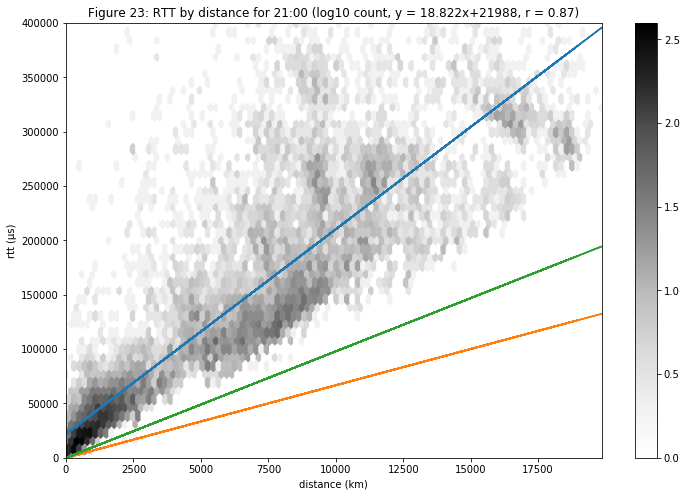

In [27]:
(linm, linb) = plot_linfit_rtt_by_dist(min_df_h[h], rtt_max=400000, label="{0:2d}:00".format(h))
plt.plot(min_df_h[h]['km'], min_df_h[h]['km'] * 2e9 / c)
plt.plot(min_df_h[h]['km'], min_df_h[h]['km'] * 2e9 * FIBER_REFRACTION / c)
h += 1

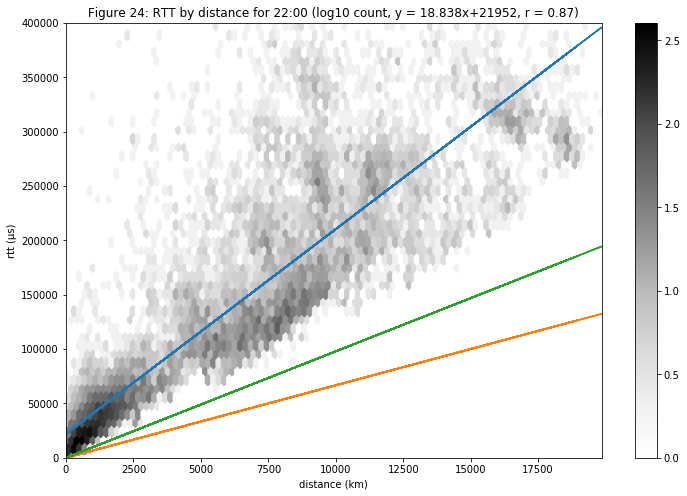

In [28]:
(linm, linb) = plot_linfit_rtt_by_dist(min_df_h[h], rtt_max=400000, label="{0:2d}:00".format(h))
plt.plot(min_df_h[h]['km'], min_df_h[h]['km'] * 2e9 / c)
plt.plot(min_df_h[h]['km'], min_df_h[h]['km'] * 2e9 * FIBER_REFRACTION / c)
h += 1

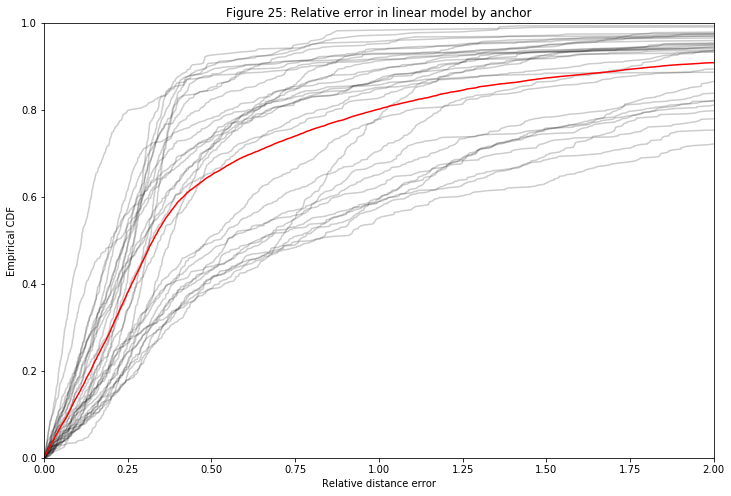

In [29]:
# derive estimated distance in kilometers from the model
min_df['lin_km'] = (min_df['minrtt'] - linb) / linm

# iterate over anchors to draw light grey lines
aid_list = min_df.index.levels[0].sort_values().values
plt.figure(figsize=(12,8))
for aid in aid_list:
    amin_df = min_df.loc[aid]
    plt.plot(ecdf(np.abs(amin_df['km'] - amin_df['lin_km']) / amin_df['km']), 'k', alpha=0.2)
plt.plot(ecdf(np.abs(min_df['km'] - min_df['lin_km']) / min_df['km']), 'r')
plt.xlim(0,2)
plt.ylim(0,1)
plt.xlabel("Relative distance error")
plt.ylabel("Empirical CDF")
plt.title(fignum("Relative error in linear model by anchor"))

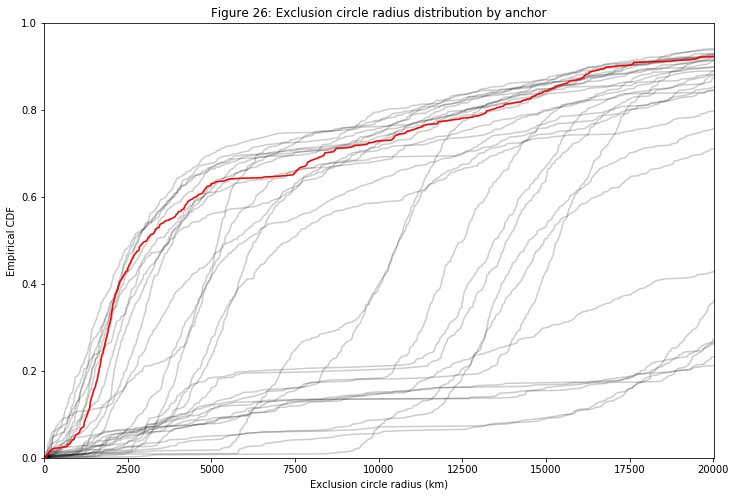

In [30]:
# iterate over anchors to draw light grey lines
aid_list = min_df.index.levels[0].sort_values().values
plt.figure(figsize=(12,8))
for aid in aid_list:
    amin_df = min_df.loc[aid]
    plt.plot(ecdf(amin_df['fiber_km']), 'k', alpha=0.2)
plt.plot(ecdf(amin_df['fiber_km']), 'r')
plt.xlim(0, math.pi * EARTH_RADIUS)
plt.ylim(0,1)
plt.xlabel("Exclusion circle radius (km)")
plt.ylabel("Empirical CDF")
plt.title(fignum("Exclusion circle radius distribution by anchor"))

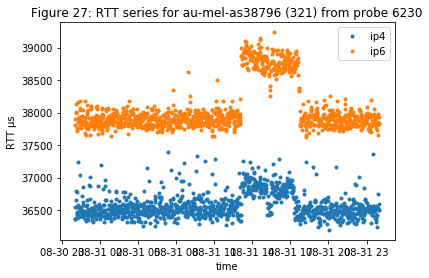

In [31]:
plot_rtt_series(321, 6230)

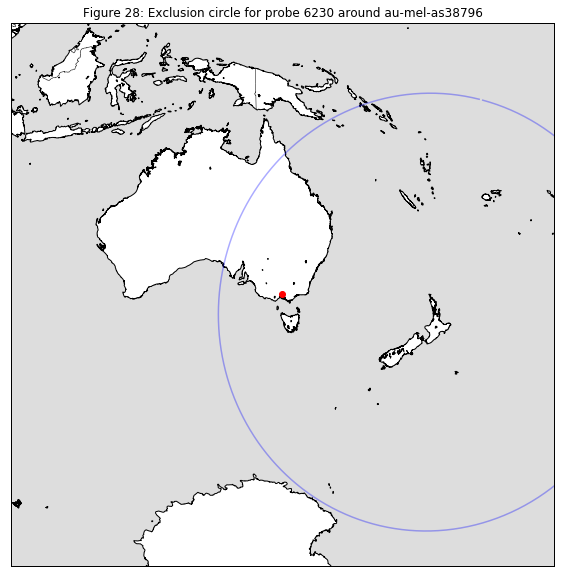

In [32]:
plot_exclusion_circles_for(321, pids=[6230], whichkm="fiber_km")

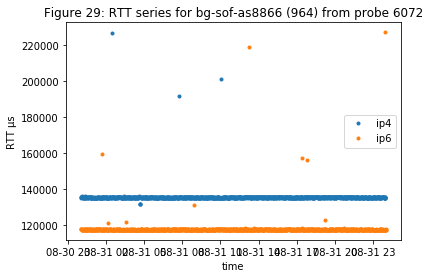

In [33]:
plot_rtt_series(964, 6072)

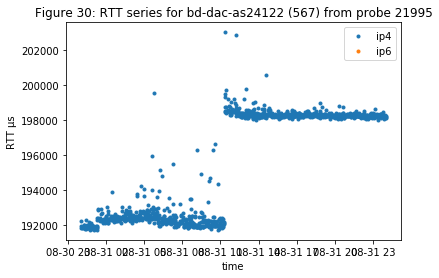

In [34]:
plot_rtt_series(567, 21995)

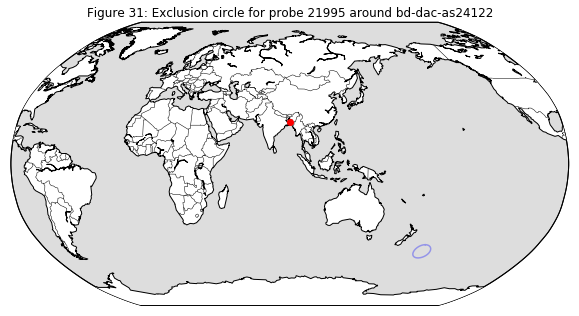

In [35]:
plot_exclusion_circles_for(567, pids=[21995], whichkm="fiber_km")

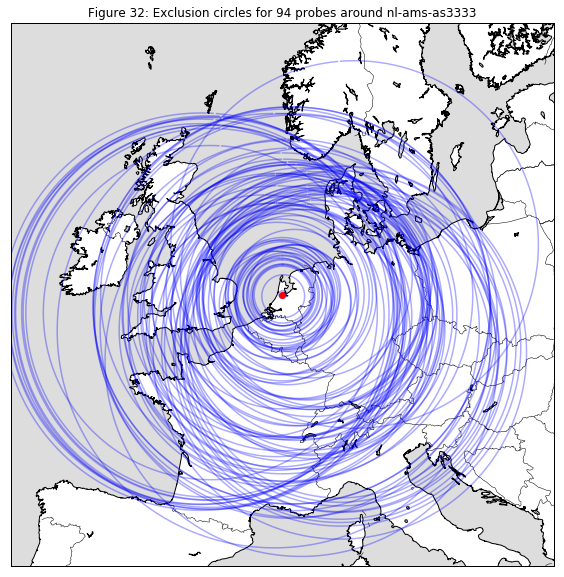

In [36]:
plot_exclusion_circles_by_rtt(12,10000)

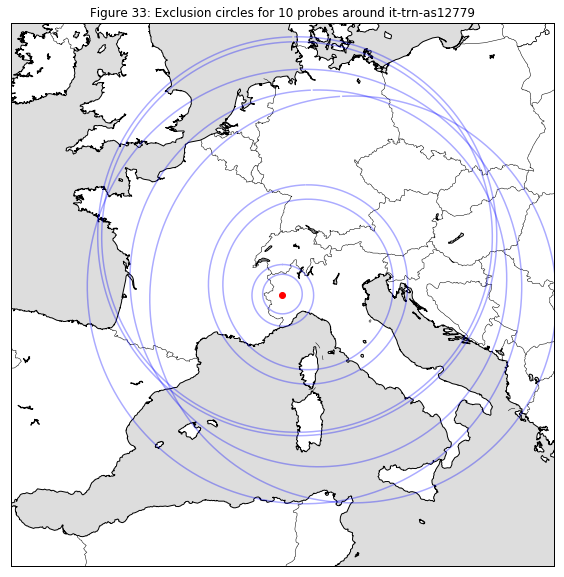

In [37]:
plot_exclusion_circles_by_rtt(4,10000)

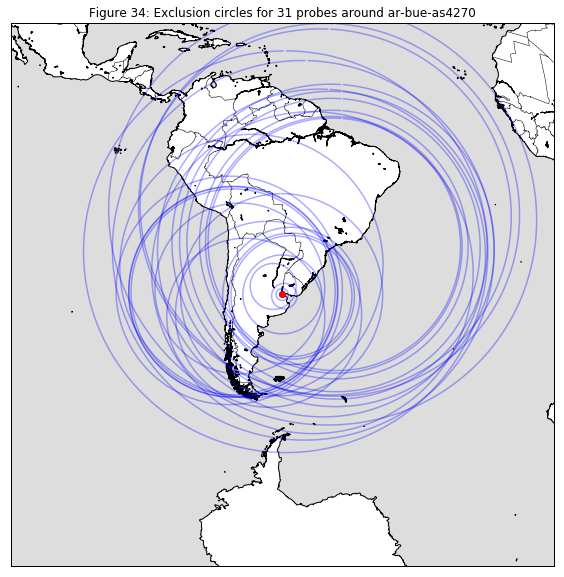

In [38]:
plot_exclusion_circles_by_rtt(669,50000)